Обучить на ваших данных полносвязную (неглубокую) нейронную сеть. В качестве образца смhttps://github.com/NikolaiZolotykh/MachineLearningCourse/blob/master/14.%20MLP%20-%20%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D1%80%D1%83%D0%BA%D0%BE%D0%BF%D0%B8%D1%81%D0%BD%D1%8B%D1%85%20%D1%86%D0%B8%D1%84%D1%80.ipynb  в репозитории https://github.com/NikolaiZolotykh/MachineLearningCourse. Попробуйте 1-2 скрытых слоя. Постройте графики зависимости ошибки на обучающей выборке и тестовой выборках от параметра alpha и от количества нейронов. Наблюдается ли переобучение/недообучение? Сделайте выводы. (Если вы работали с нейронными сетями раньше, вы можете использовать любую библиотеку на ваш выбор - torch, caffe, tensorflow и т.д. - и любую архитектуру нейронной сети


# Домашнее задание №2
## **Применение нейронных сетей для классификации**
#### Выполнил: Артамонов Д., МАГ ИАД 2020
https://www.kaggle.com/gauravdesurkar/lt-vehicle-loan-default-prediction

архитектуры:

* числоскрытых слоёв
* батч норма
* инициализация? 

https://towardsdatascience.com/how-to-code-a-simple-neural-network-in-pytorch-for-absolute-beginners-8f5209c50fdd

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
import torch
import os

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Вспомним как выглядят наши данные

In [2]:
data_path = 'VehicleLoanDefaultPrediction'
data = pd.read_csv(os.path.join(data_path, 'train.csv'))

In [40]:
data.head(5)

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


Несбалансированность классов:

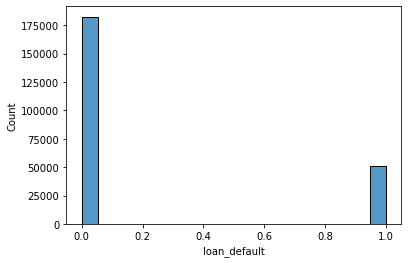

In [60]:
sns.histplot(data=data, x="loan_default")
plt.show()

Всю логику по препроцессингу данных реализуем внутри Pytroch Dataset. При инициализации он будет принимать путь к csv-табличке, считывать  обрабатывать данные, а также балансировать классы. Так как данных достаточно, в качестве балансировки мы можем просто удалить часть данных "перевешивающего" класса. Датасет сам разделит данные на train/test и будет выдавать нужные в зависимости от режима(train/test)

In [87]:
import loan_dataset

In [100]:
dataset = loan_dataset.VehicleLoanDataset(os.path.join(data_path, 'train.csv'), balance=True, mode='train', test_size=0.2)

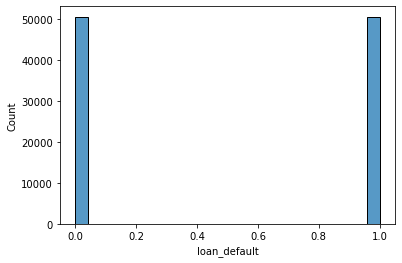

In [101]:
sns.histplot(dataset.data, x="loan_default")
plt.show()

Размеры тренировочной и тестовой выборок

In [102]:
dataset.X_train.shape

(80977, 35)

In [103]:
dataset.X_test.shape

(20245, 35)

Инициализируем даталоадер, с помощью которого мы будем итерироваться по выборке

In [106]:
dataloader = DataLoader(dataset, batch_size=1000, shuffle=False, num_workers=2)

## Пробуем различные архитектуры

Размерность входа и выхода меняться не будут. Зададим их сразу

In [108]:
input_size = dataset.get_shape()[1]
output_size = 2

In [97]:
from torch.nn import Sequential
import torch.nn as nn

In [113]:
# Hyperparameters for our network

hidden_sizes = [64]

# Build a feed-forward network
model = Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], output_size),
                      Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=35, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=2, bias=True)
  (3): Softmax(dim=1)
)


In [112]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')